# Importing Libraries

In [17]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.engine import data_adapter
from huggingface_hub import Repository, list_repo_files
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.saving import hdf5_format
from transformers.utils.hub import convert_file_size_to_int, get_checkpoint_shard_files
from huggingface_hub import Repository, list_repo_files
from transformers.utils.hub import convert_file_size_to_int, get_checkpoint_shard_files
from huggingface_hub import Repository, list_repo_files
from transformers.utils.hub import convert_file_size_to_int, get_checkpoint_shard_files
import tensorflow_datasets as tfds
from transformers import TFSegformerForSemanticSegmentation
from tqdm import tqdm
import time

# Importing the Dataset

In [4]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

In [10]:
import tensorflow as tf
from tensorflow.keras import backend
image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])

# Augmentation

In [9]:
def load_image(datapoint, augment=True):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    if augment:
        # Randomly flip the image horizontally
        if tf.random.uniform(()) > 0.5:
            input_image = tf.image.flip_left_right(input_image)
            input_mask = tf.image.flip_left_right(input_mask)

        # Randomly adjust the brightness and saturation of the image
        input_image = tf.image.random_brightness(input_image, 0.1)
        input_image = tf.image.random_saturation(input_image, 0.8, 1.2)

    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))

    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

# Normalization

In [12]:
def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )

    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

# Preparing training and testing Dataset

In [13]:
auto = tf.data.AUTOTUNE
batch_size = 4

train_ds = (
    dataset["train"]
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
test_ds = (
    dataset["test"]
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

In [14]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


# Plotting the images

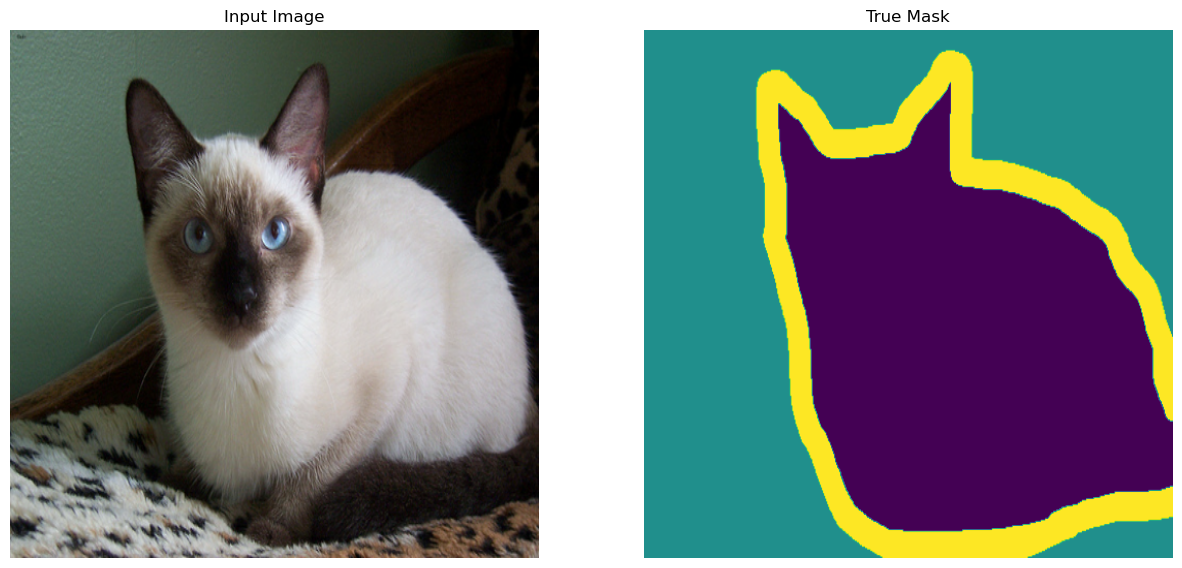

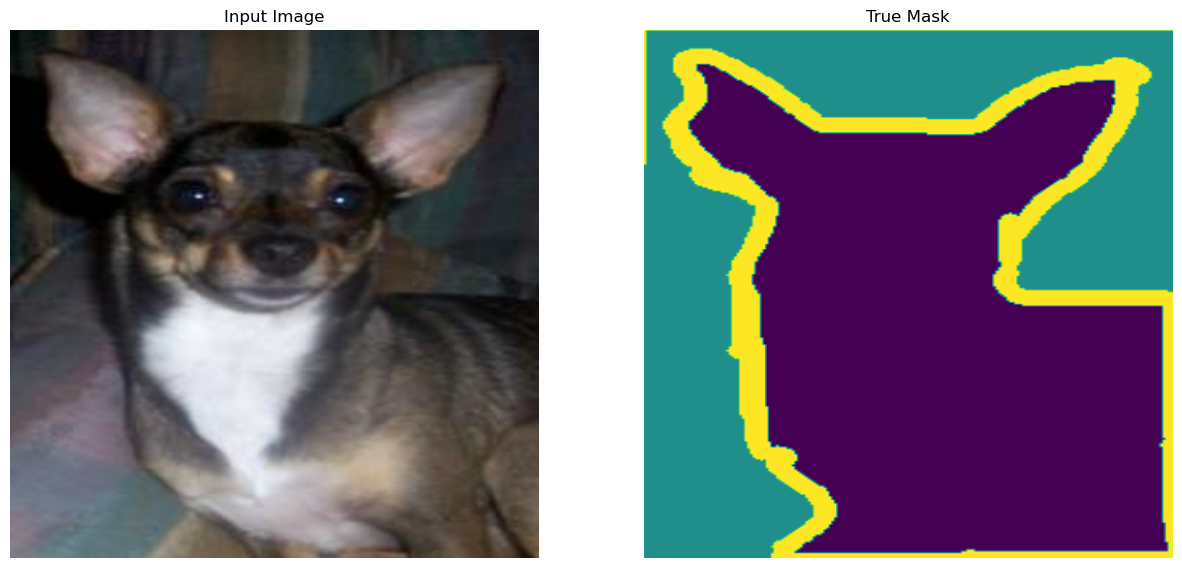

In [8]:
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

# Dynaic Learning Rate

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    """
    A function that takes an epoch index as input and returns a new learning rate
    for that epoch. This function can be customized to implement various schedules,
    such as step decay or exponential decay.
    """
    lr = 0.001
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [18]:

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1: "inner", 2: "border"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
accuracies=[0.51, 0.57, 0.63, 0.68, 0.74, 0.73, 0.8, 0.72, 0.81, 0.82, 0.83, 0.84, 0.86, 0.82, 0.83, 0.85, 0.82, 0.83, 0.82, 0.85, 0.85, 0.85, 0.85, 0.85, 0.86, 0.86, 0.86, 0.87, 0.88, 0.88]

# Module compiler

In [19]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [24]:
from IPython.display import clear_output

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], masks[0]])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

# Training the model

In [44]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[DisplayCallback(train_ds)],
    epochs=epochs,
)




█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/



█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/



█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/



█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/



█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/



█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/



█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/



█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/



█████████████

# Showing predictions

1/1 [==============================] - 2s 2s/step


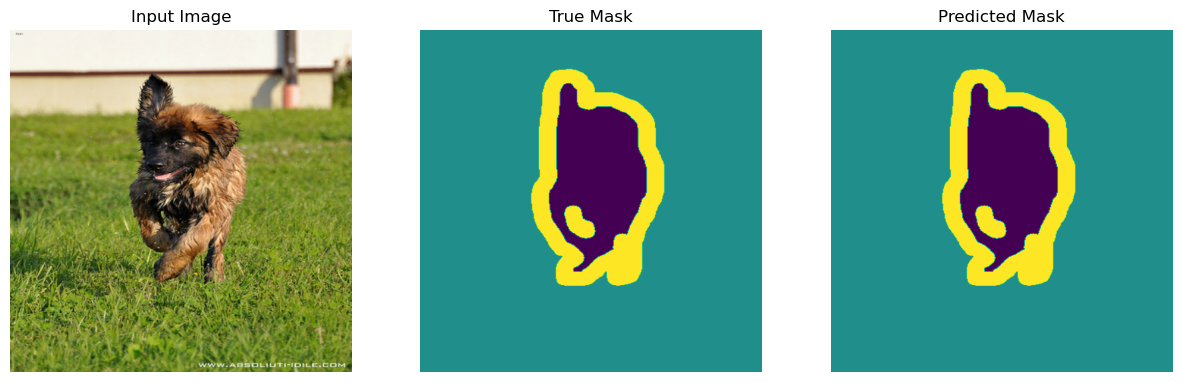

1/1 [==============================] - 2s 2s/step


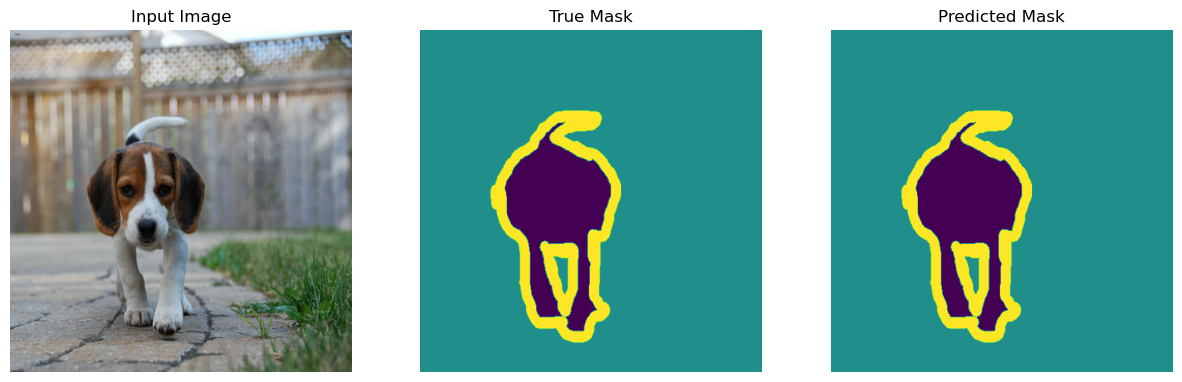

1/1 [==============================] - 2s 2s/step


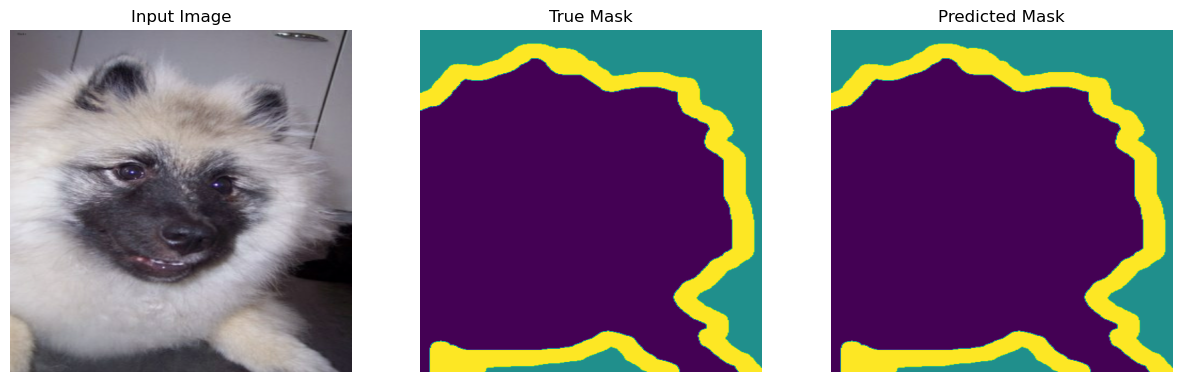

1/1 [==============================] - 2s 2s/step


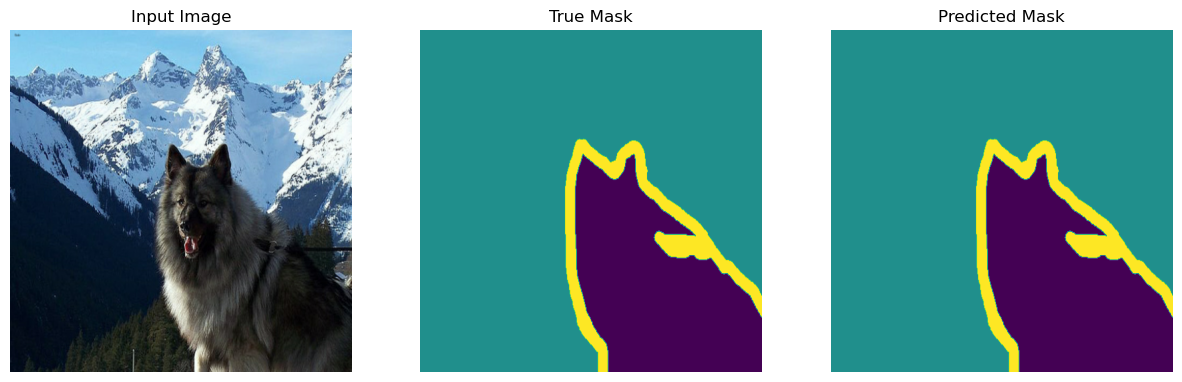

1/1 [==============================] - 2s 2s/step


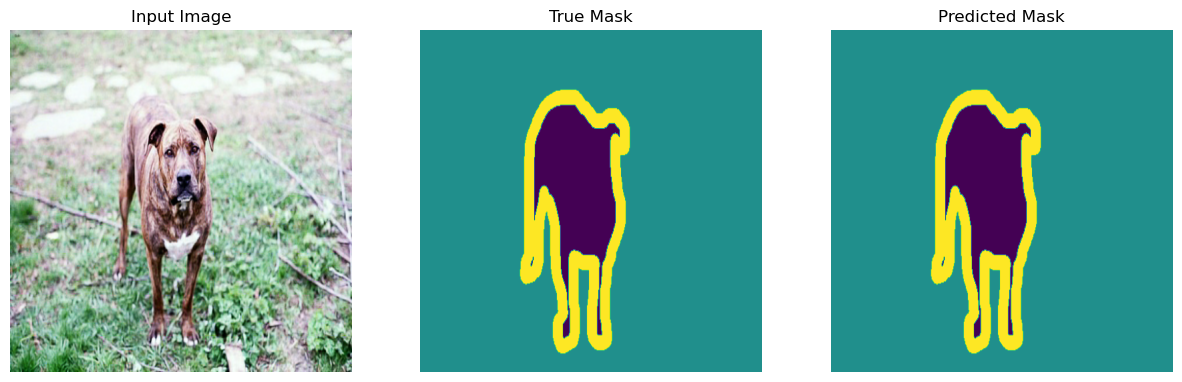

In [26]:
show_predictions(test_ds, 5)

# Model Evaluation

In [ ]:
evaluation== model.evaluate(test_ds)

In [40]:
eval = model.evaluate(test_ds)

918/918 [==============================] - 2771s 3s/step - loss: 0.2237


In [66]:
eval

0.22368930280208588

# Mean IoU Evaluation

In [45]:
def calculate_iou(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / union
    return iou

In [85]:
def evaluate(model, dataset):
    ious = []
    for sample in dataset:
        images, masks = sample["pixel_values"], sample["labels"]
        pred_masks = model.predict(images).logits
        pred_masks = create_mask(pred_masks)
        masks = tf.image.resize(masks, (128, 128), method='bicubic')
        masks = tf.expand_dims(masks[..., 0], axis=-1)
        iou = calculate_iou(masks, pred_masks)
        ious.append(iou)
        mean_iou = tf.reduce_mean(ious)
        return mean_iou

mean_iou = evaluate(model, test_ds)
print("Mean IoU:", mean_iou.numpy())

1/1 [==============================] - 6s 6s/step
Mean IoU: 0.95643127


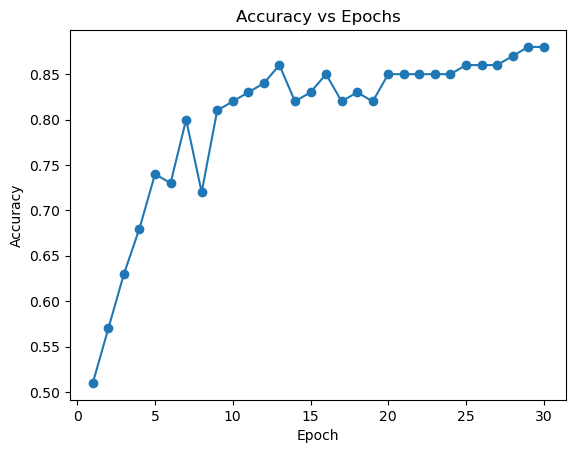

In [60]:
import matplotlib.pyplot as plt
accuracy_values = accuracies
# Set the number of epochs
epochs = len(accuracy_values)
# Create a list of epoch numbers
epoch_numbers = list(range(1, epochs+1))
# Plot the accuracy values against epoch numbers
plt.plot(epoch_numbers, accuracy_values, marker='o')
# Set the x-axis and y-axis labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
# Show the plot
plt.show()
